In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Colab_Pro/DLCV/HW1
#change directory to AI_LAB3

/content/drive/MyDrive/Colab_Pro/DLCV/HW1


In [3]:
!bash get_dataset.sh

Traceback (most recent call last):
  File "/usr/local/bin/gdown", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/gdown/__main__.py", line 172, in main
    download(
  File "/usr/local/lib/python3.10/dist-packages/gdown/download.py", line 202, in download
    res = sess.get(url, stream=True, verify=verify)
  File "/usr/local/lib/python3.10/dist-packages/requests/sessions.py", line 602, in get
    return self.request("GET", url, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/requests/sessions.py", line 589, in request
    resp = self.send(prep, **send_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/requests/sessions.py", line 703, in send
    r = adapter.send(request, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/requests/adapters.py", line 667, in send
    resp = conn.urlopen(
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py", line 789, in urlopen
    response = self._make_request(
  File "

In [13]:
!pip3 install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.2/797.2 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/

# Import library

packages allowed for use during inference

In [3]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from torchvision.models.segmentation import deeplabv3_resnet101, DeepLabV3_ResNet101_Weights
import torchvision


import imageio.v2 as imageio
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm


from P2_train_val_CustomDataset import P2_CustomDataset
from P2_train_val_CustomTransform import CustomTransform




In [5]:
print(torch.__version__)

2.4.0+cu121


# Hyperparameters

In [6]:
BATCH_SIZE = 8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Custom Dataset

custom dataset

problem: 不知道為什麼在另一個file建P2_CustomDataset class，更新class後這個file不會同步更新

先計算此training dataset的mean & std

In [7]:
# 計算normalization需要的mean & std
def get_mean_std(dataset):
    # Get mean and std by sample ratio
    dataloader = DataLoader(dataset, batch_size=int(len(dataset)), shuffle=True, num_workers=2)

    image = next(iter(dataloader))[0]     # get the first batch's all image data([0]: image, [1]: mask)
    mean = np.mean(image.numpy(), axis=(0,2,3))
    std = np.std(image.numpy(), axis=(0,2,3))
    return mean, std

#train_dataset_meanstd = P2_CustomDataset(data_dir='../hw1_data/p2_data/train', transform=transforms.ToTensor()) #transforms.ToTensor(): divide pixel value by 255


#train_mean, train_std = get_mean_std(train_dataset_meanstd)
#print(train_mean, train_std)

In [7]:
train_mean = [0.4085139,  0.37851316, 0.28088593]
train_std = [0.14234419, 0.10848381, 0.09824713]

建train transform和val transform

val transform和test transform一樣

In [8]:
# data augmentation & normalization
# (如果image翻轉或平移，mask也應翻轉或平移)
transform_train = CustomTransform(p=0.5, mean=train_mean, std=train_std) #水平, 垂直flipped

transform_val = CustomTransform(p=0, mean=train_mean, std=train_std)

用P2_train_val_CustomDataset產生custom train & val dataset，再產生trainloader & valloader

In [9]:
train_dataset = P2_CustomDataset(data_dir='./hw1_data/p2_data/train', transform=transform_train)
val_dataset = P2_CustomDataset(data_dir='./hw1_data/p2_data/validation', transform=transform_val)

trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [10]:
# print shape
image_first_batch, mask_first_batch = next(iter(trainloader))  #get first batch's image & mask
print("type(image_first_batch): ", type(image_first_batch))
print("image_first_batch.shape: ", image_first_batch.shape)
print("type(mask_first_batch): ", type(mask_first_batch))
print("mask_first_batch.shape: ", mask_first_batch.shape)

type(image_first_batch):  <class 'torch.Tensor'>
image_first_batch.shape:  torch.Size([8, 3, 512, 512])
type(mask_first_batch):  <class 'torch.Tensor'>
mask_first_batch.shape:  torch.Size([8, 1, 512, 512])


In [11]:
print(image_first_batch[2][0][100][200])
print(mask_first_batch[2][0][100][200])

tensor(0.2708)
tensor(1, dtype=torch.uint8)


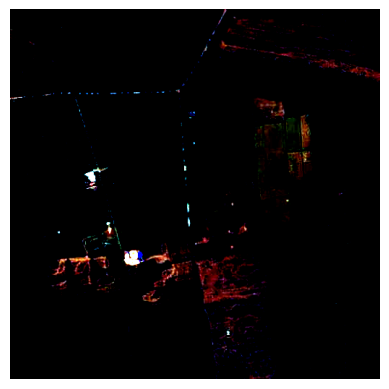

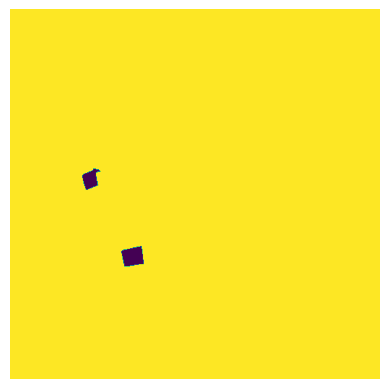

In [13]:
# visualize wo normalization
idx = 0
first_image = image_first_batch[idx]
first_mask = mask_first_batch[idx]

# Convert the tensor to numpy array
image_np = first_image.numpy()
mask_np = first_mask.numpy()
# Since matplotlib expects images in H x W x C format, we need to transpose it
image_np = np.transpose(image_np, (1, 2, 0))
mask_np = np.transpose(mask_np, (1, 2, 0))

# Plot the image
plt.imshow(image_np)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()
plt.imshow(mask_np)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

In [12]:
print(torch.cuda.is_available())

True


# Build Model

instance model

並放到device上(gpu?)


In [13]:
"""
def change_output_channel(n_classes=7):
    # Load pretrained backbone
    model = deeplabv3_resnet101(weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1)
    model.classifier[4] = nn.Conv2d(256, n_classes, kernel_size=(1, 1))
    return model
#cuz deeplabv3 has dict output
class DeepLabV3_ResNet101(nn.Module):
    def __init__(self, n_classes=7):
        super(DeepLabV3_ResNet101, self).__init__()
        self.model = change_output_channel(n_classes)
    def forward(self, x):
        x = self.model(x)['out']
        return x
"""

In [ ]:
class DeepLabV3_ResNet101(nn.Module):
    def __init__(self, n_classes=7):
        super(DeepLabV3_ResNet101, self).__init__()
        self.model = self.change_output_channel(n_classes)
        
    def forward(self, x):
        return self.model(x)['out']

    def change_output_channel(self, n_classes=7):
        # Load pretrained backbone
        model = deeplabv3_resnet101(weights=None)
        model.classifier[4] = nn.Conv2d(256, n_classes, kernel_size=(1, 1))  
        return model

In [14]:
net = DeepLabV3_ResNet101(n_classes=7).to(device)

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:01<00:00, 207MB/s]


# Training

Loss and Optimizer and epoch_n

In [15]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        CE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-CE_loss)  # Prevents numerical instability
        F_loss = self.alpha * (1 - pt) ** self.gamma * CE_loss

        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

In [16]:

criterion = FocalLoss(alpha=0.25, gamma=2.0)
# Initialize optimizer
optimizer = optim.Adam(net.parameters(), lr=0.0001, betas=(0.8, 0.999), weight_decay=1e-5)
# Different base learning rate and update strategy #!!!!!!
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)  #if 10個epoch沒進步==> lr *= 0.5
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.6, last_epoch=-1)
# number of epoch
num_epochs = 100

mIoU 計算

In [17]:
def compute_miou(pred, target, num_classes):

    '''pred: model's output. shape is (len(dataset), n_classes, H, W).
    target: The ground truth mask. shape is [len(dataset), H, W] where each pixel is a class label'''

    # model, input image, output, mask(target, label, GT) are moved to GPU during training
    pred = torch.argmax(pred, dim=1).cpu().numpy()
    target = target.cpu().numpy()

    iou_list = []
    for i in range(num_classes - 1): # num_classes - 1: do not inculde unknown class
        intersection = np.sum((pred == i) & (target == i))  # 交集: TP
        union = np.sum((pred == i) | (target == i)) # 聯集: TP + FP + FN

        if union == 0:
            #continue  # Skip if union is zero (i.e., no pixels belong to this class in pred or target in this dataset)
            iou = 0
        else:
            iou = intersection / union  # Normal IoU calculation when union is non-zer
        iou_list.append(iou)

    return np.mean(iou_list)

training & validation loop

In [18]:
# Training and Validation Loop
best_miou = 0
train_loss_list = []
val_loss_list = []
val_mIoU_list = []

last_lr = optimizer.param_groups[0]['lr']

for epoch in range(num_epochs):

    net.train() #開啟BN & DROPOUT
    train_loss = 0

    for images, targets in tqdm(trainloader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch'):  #進度條以batch完成度為趴數

        images, targets = images.to(device), targets.to(device)# model, input image, output, mask(target, label, GT) are moved to GPU during training

        optimizer.zero_grad()

        outputs = net(images)
        #print(outputs.shape, targets.shape) #outputs:  torch.Size([8, 7, 512, 512]); targets: torch.Size([8, 1, 512, 512])


        # criterion & compute_miou expect targets shape is N*H*W
        if targets.size(1) == 1:
            targets = targets.squeeze(1)  # Remove the channel dimension if it's 1

        loss = criterion(outputs, targets.long())#expect mask is float64


        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(trainloader)

    # Validate
    net.eval() #關掉BN & DROPOUT
    val_loss = 0

    all_preds = []
    all_targets = []
    with torch.no_grad():
        for images, targets in tqdm(valloader, desc='Validation', unit='batch'):
            images, targets = images.to(device), targets.to(device)

            outputs = net(images)  #(bs, 7, 512, 512)

            # criterion & compute_miou expect targets shape is N*H*W
            if targets.size(1) == 1:
                targets = targets.squeeze(1)  # Remove the channel dimension if it's 1
            loss = criterion(outputs, targets.long()) #expect mask is float64


            val_loss += loss.item()

            all_preds.append(outputs.cpu())
            all_targets.append(targets.cpu())

    val_loss /= len(valloader)

    # all_preds in (k, bs, 7, 512, 512), list of tensor
    all_preds = torch.cat(all_preds)  # all_preds in (k*bs, 7, 512, 512), a Tensor, k*bs = len(dataset)
    # all_targets in (k, bs, 512, 512), list of tensor
    all_targets = torch.cat(all_targets)# all_targets in (k*bs, 512, 512), a Tensor, k*bs = len(dataset)

    val_miou = compute_miou(all_preds, all_targets, num_classes = 7)

    # Save best model # save the whole model include architecture
    if val_miou > best_miou:
        best_miou = val_miou
        torch.save(net.state_dict(), os.path.join("checkpoint_model_deeplabv3", "best_val_mIoU_model.pth"))
        print(f'Saved best model with mIoU: {best_miou:.4f}')

    # Save the model at the 1st epoch, midpoint, and final epoch
    if epoch == 0:
        torch.save(net.state_dict(), os.path.join("checkpoint_model_deeplabv3",f'epoch_1st.pth'))
        print(f'Saved model for epoch {epoch + 1}')
    elif epoch == num_epochs // 2:
        torch.save(net.state_dict(), os.path.join("checkpoint_model_deeplabv3",f'epoch_midpoint.pth'))
        print(f'Saved model for epoch {epoch + 1}')
    elif epoch == num_epochs - 1:
        torch.save(net.state_dict(), os.path.join("checkpoint_model_deeplabv3",f'epoch_final.pth'))
        print(f'Saved model for epoch {epoch + 1}')



    # Logging
    print(f'Epoch {epoch + 1}/{num_epochs} - Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - Val mIoU: {val_miou:.4f}')
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    val_mIoU_list.append(val_miou)

    scheduler.step(val_miou)

    # Check for learning rate reduction
    current_lr = scheduler.get_last_lr()[0]  # Access the updated learning rate
    if current_lr < last_lr:
        print(f'Learning rate reduced to {current_lr:.6f} (was {last_lr:.6f})')
        last_lr = current_lr

Validation: 100%|██████████| 33/33 [01:22<00:00,  2.51s/batch]


Saved best model with mIoU: 0.6361
Saved model for epoch 1
Epoch 1/100 - Loss: 0.1297 - Val Loss: 0.0655 - Val mIoU: 0.6361


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.13batch/s]


Saved best model with mIoU: 0.6606
Epoch 2/100 - Loss: 0.0784 - Val Loss: 0.0497 - Val mIoU: 0.6606


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.20batch/s]


Saved best model with mIoU: 0.6850
Epoch 3/100 - Loss: 0.0656 - Val Loss: 0.0451 - Val mIoU: 0.6850


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.14batch/s]


Epoch 4/100 - Loss: 0.0582 - Val Loss: 0.0409 - Val mIoU: 0.6679


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.15batch/s]


Epoch 5/100 - Loss: 0.0486 - Val Loss: 0.0418 - Val mIoU: 0.6779


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.14batch/s]


Saved best model with mIoU: 0.7072
Epoch 6/100 - Loss: 0.0454 - Val Loss: 0.0356 - Val mIoU: 0.7072


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.16batch/s]


Saved best model with mIoU: 0.7076
Epoch 7/100 - Loss: 0.0419 - Val Loss: 0.0364 - Val mIoU: 0.7076


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.19batch/s]


Saved best model with mIoU: 0.7130
Epoch 8/100 - Loss: 0.0411 - Val Loss: 0.0339 - Val mIoU: 0.7130


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.14batch/s]


Epoch 9/100 - Loss: 0.0401 - Val Loss: 0.0375 - Val mIoU: 0.6958


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.14batch/s]


Epoch 10/100 - Loss: 0.0378 - Val Loss: 0.0378 - Val mIoU: 0.6912


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.13batch/s]


Epoch 11/100 - Loss: 0.0379 - Val Loss: 0.0317 - Val mIoU: 0.7122


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.16batch/s]


Saved best model with mIoU: 0.7135
Epoch 12/100 - Loss: 0.0329 - Val Loss: 0.0323 - Val mIoU: 0.7135


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.20batch/s]


Saved best model with mIoU: 0.7276
Epoch 13/100 - Loss: 0.0286 - Val Loss: 0.0313 - Val mIoU: 0.7276


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.13batch/s]


Epoch 14/100 - Loss: 0.0285 - Val Loss: 0.0328 - Val mIoU: 0.7149


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.17batch/s]


Epoch 15/100 - Loss: 0.0306 - Val Loss: 0.0331 - Val mIoU: 0.7206


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.14batch/s]


Epoch 16/100 - Loss: 0.0282 - Val Loss: 0.0321 - Val mIoU: 0.7264


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.17batch/s]


Epoch 17/100 - Loss: 0.0284 - Val Loss: 0.0318 - Val mIoU: 0.7157


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.17batch/s]


Saved best model with mIoU: 0.7352
Epoch 18/100 - Loss: 0.0278 - Val Loss: 0.0316 - Val mIoU: 0.7352


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.19batch/s]


Epoch 19/100 - Loss: 0.0272 - Val Loss: 0.0327 - Val mIoU: 0.7293


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.17batch/s]


Epoch 20/100 - Loss: 0.0268 - Val Loss: 0.2368 - Val mIoU: 0.4827


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.18batch/s]


Saved best model with mIoU: 0.7394
Epoch 21/100 - Loss: 0.0272 - Val Loss: 0.0279 - Val mIoU: 0.7394


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.15batch/s]


Epoch 22/100 - Loss: 0.0226 - Val Loss: 0.0311 - Val mIoU: 0.7228


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.19batch/s]


Epoch 23/100 - Loss: 0.0210 - Val Loss: 0.0322 - Val mIoU: 0.7296


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.15batch/s]


Epoch 24/100 - Loss: 0.0214 - Val Loss: 0.0382 - Val mIoU: 0.6821


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.19batch/s]


Epoch 25/100 - Loss: 0.0213 - Val Loss: 0.0289 - Val mIoU: 0.7306


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.23batch/s]


Epoch 26/100 - Loss: 0.0184 - Val Loss: 0.0297 - Val mIoU: 0.7346


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.16batch/s]


Epoch 27/100 - Loss: 0.0217 - Val Loss: 0.0329 - Val mIoU: 0.7305
Learning rate reduced to 0.000050 (was 0.000100)


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.23batch/s]


Saved best model with mIoU: 0.7528
Epoch 28/100 - Loss: 0.0166 - Val Loss: 0.0286 - Val mIoU: 0.7528


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.20batch/s]


Epoch 29/100 - Loss: 0.0147 - Val Loss: 0.0320 - Val mIoU: 0.7300


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.18batch/s]


Epoch 30/100 - Loss: 0.0134 - Val Loss: 0.0298 - Val mIoU: 0.7394


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.21batch/s]


Epoch 31/100 - Loss: 0.0125 - Val Loss: 0.0298 - Val mIoU: 0.7504


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.19batch/s]


Epoch 32/100 - Loss: 0.0124 - Val Loss: 0.0310 - Val mIoU: 0.7455


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.22batch/s]


Epoch 33/100 - Loss: 0.0117 - Val Loss: 0.0291 - Val mIoU: 0.7491


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.22batch/s]


Saved best model with mIoU: 0.7555
Epoch 34/100 - Loss: 0.0109 - Val Loss: 0.0296 - Val mIoU: 0.7555


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.21batch/s]


Epoch 35/100 - Loss: 0.0110 - Val Loss: 0.0317 - Val mIoU: 0.7471


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.22batch/s]


Epoch 36/100 - Loss: 0.0111 - Val Loss: 0.0322 - Val mIoU: 0.7438


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.16batch/s]


Epoch 37/100 - Loss: 0.0102 - Val Loss: 0.0304 - Val mIoU: 0.7527


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.18batch/s]


Epoch 38/100 - Loss: 0.0101 - Val Loss: 0.0307 - Val mIoU: 0.7493


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.16batch/s]


Epoch 39/100 - Loss: 0.0094 - Val Loss: 0.0332 - Val mIoU: 0.7428


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.14batch/s]


Epoch 40/100 - Loss: 0.0090 - Val Loss: 0.0329 - Val mIoU: 0.7463
Learning rate reduced to 0.000025 (was 0.000050)


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.15batch/s]


Epoch 41/100 - Loss: 0.0083 - Val Loss: 0.0319 - Val mIoU: 0.7522


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.15batch/s]


Epoch 42/100 - Loss: 0.0076 - Val Loss: 0.0320 - Val mIoU: 0.7550


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.16batch/s]


Epoch 43/100 - Loss: 0.0084 - Val Loss: 0.0319 - Val mIoU: 0.7539


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.14batch/s]


Epoch 44/100 - Loss: 0.0074 - Val Loss: 0.0339 - Val mIoU: 0.7491


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.18batch/s]


Epoch 45/100 - Loss: 0.0068 - Val Loss: 0.0348 - Val mIoU: 0.7514


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.17batch/s]


Saved best model with mIoU: 0.7558
Epoch 46/100 - Loss: 0.0065 - Val Loss: 0.0349 - Val mIoU: 0.7558


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.16batch/s]


Epoch 47/100 - Loss: 0.0063 - Val Loss: 0.0363 - Val mIoU: 0.7511


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.21batch/s]


Epoch 48/100 - Loss: 0.0061 - Val Loss: 0.0369 - Val mIoU: 0.7536


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.14batch/s]


Epoch 49/100 - Loss: 0.0059 - Val Loss: 0.0350 - Val mIoU: 0.7536


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.15batch/s]


Epoch 50/100 - Loss: 0.0060 - Val Loss: 0.0352 - Val mIoU: 0.7551


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.13batch/s]


Saved best model with mIoU: 0.7565
Saved model for epoch 51
Epoch 51/100 - Loss: 0.0060 - Val Loss: 0.0344 - Val mIoU: 0.7565


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.18batch/s]


Epoch 52/100 - Loss: 0.0063 - Val Loss: 0.0345 - Val mIoU: 0.7549


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.20batch/s]


Epoch 53/100 - Loss: 0.0058 - Val Loss: 0.0351 - Val mIoU: 0.7508


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.14batch/s]


Epoch 54/100 - Loss: 0.0056 - Val Loss: 0.0353 - Val mIoU: 0.7563


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.13batch/s]


Epoch 55/100 - Loss: 0.0053 - Val Loss: 0.0365 - Val mIoU: 0.7554


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.13batch/s]


Epoch 56/100 - Loss: 0.0052 - Val Loss: 0.0383 - Val mIoU: 0.7560


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.14batch/s]


Epoch 57/100 - Loss: 0.0051 - Val Loss: 0.0361 - Val mIoU: 0.7555
Learning rate reduced to 0.000013 (was 0.000025)


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.14batch/s]


Saved best model with mIoU: 0.7573
Epoch 58/100 - Loss: 0.0047 - Val Loss: 0.0369 - Val mIoU: 0.7573


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.19batch/s]


Epoch 59/100 - Loss: 0.0045 - Val Loss: 0.0373 - Val mIoU: 0.7561


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.15batch/s]


Epoch 60/100 - Loss: 0.0044 - Val Loss: 0.0394 - Val mIoU: 0.7545


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.17batch/s]


Epoch 61/100 - Loss: 0.0042 - Val Loss: 0.0383 - Val mIoU: 0.7562


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.15batch/s]


Saved best model with mIoU: 0.7583
Epoch 62/100 - Loss: 0.0042 - Val Loss: 0.0387 - Val mIoU: 0.7583


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.16batch/s]


Epoch 63/100 - Loss: 0.0040 - Val Loss: 0.0385 - Val mIoU: 0.7581


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.13batch/s]


Epoch 64/100 - Loss: 0.0040 - Val Loss: 0.0386 - Val mIoU: 0.7556


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.10batch/s]


Saved best model with mIoU: 0.7598
Epoch 65/100 - Loss: 0.0040 - Val Loss: 0.0389 - Val mIoU: 0.7598


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.19batch/s]


Epoch 66/100 - Loss: 0.0041 - Val Loss: 0.0375 - Val mIoU: 0.7583


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.17batch/s]


Epoch 67/100 - Loss: 0.0039 - Val Loss: 0.0389 - Val mIoU: 0.7575


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.17batch/s]


Epoch 68/100 - Loss: 0.0038 - Val Loss: 0.0403 - Val mIoU: 0.7546


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.17batch/s]


Epoch 69/100 - Loss: 0.0037 - Val Loss: 0.0380 - Val mIoU: 0.7567


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.17batch/s]


Epoch 70/100 - Loss: 0.0037 - Val Loss: 0.0398 - Val mIoU: 0.7582


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.17batch/s]


Saved best model with mIoU: 0.7599
Epoch 71/100 - Loss: 0.0036 - Val Loss: 0.0401 - Val mIoU: 0.7599


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.15batch/s]


Epoch 72/100 - Loss: 0.0037 - Val Loss: 0.0422 - Val mIoU: 0.7521


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.18batch/s]


Epoch 73/100 - Loss: 0.0035 - Val Loss: 0.0411 - Val mIoU: 0.7563


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.14batch/s]


Epoch 74/100 - Loss: 0.0036 - Val Loss: 0.0405 - Val mIoU: 0.7587


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.19batch/s]


Epoch 75/100 - Loss: 0.0035 - Val Loss: 0.0415 - Val mIoU: 0.7581


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.16batch/s]


Saved best model with mIoU: 0.7601
Epoch 76/100 - Loss: 0.0033 - Val Loss: 0.0410 - Val mIoU: 0.7601


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.18batch/s]


Saved best model with mIoU: 0.7618
Epoch 77/100 - Loss: 0.0034 - Val Loss: 0.0409 - Val mIoU: 0.7618


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.14batch/s]


Epoch 78/100 - Loss: 0.0033 - Val Loss: 0.0421 - Val mIoU: 0.7612


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.18batch/s]


Epoch 79/100 - Loss: 0.0033 - Val Loss: 0.0420 - Val mIoU: 0.7598


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.17batch/s]


Epoch 80/100 - Loss: 0.0033 - Val Loss: 0.0421 - Val mIoU: 0.7578


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.19batch/s]


Epoch 81/100 - Loss: 0.0032 - Val Loss: 0.0419 - Val mIoU: 0.7605


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.19batch/s]


Epoch 82/100 - Loss: 0.0031 - Val Loss: 0.0445 - Val mIoU: 0.7582


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.20batch/s]


Epoch 83/100 - Loss: 0.0033 - Val Loss: 0.0428 - Val mIoU: 0.7509
Learning rate reduced to 0.000006 (was 0.000013)


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.16batch/s]


Epoch 84/100 - Loss: 0.0033 - Val Loss: 0.0410 - Val mIoU: 0.7570


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.19batch/s]


Epoch 85/100 - Loss: 0.0029 - Val Loss: 0.0433 - Val mIoU: 0.7572


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.15batch/s]


Epoch 86/100 - Loss: 0.0029 - Val Loss: 0.0441 - Val mIoU: 0.7550


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.16batch/s]


Epoch 87/100 - Loss: 0.0029 - Val Loss: 0.0449 - Val mIoU: 0.7556


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.16batch/s]


Epoch 88/100 - Loss: 0.0028 - Val Loss: 0.0446 - Val mIoU: 0.7578


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.14batch/s]


Epoch 89/100 - Loss: 0.0027 - Val Loss: 0.0449 - Val mIoU: 0.7573
Learning rate reduced to 0.000003 (was 0.000006)


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.18batch/s]


Epoch 90/100 - Loss: 0.0027 - Val Loss: 0.0435 - Val mIoU: 0.7585


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.14batch/s]


Epoch 91/100 - Loss: 0.0026 - Val Loss: 0.0444 - Val mIoU: 0.7589


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.20batch/s]


Epoch 92/100 - Loss: 0.0026 - Val Loss: 0.0431 - Val mIoU: 0.7581


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.19batch/s]


Epoch 93/100 - Loss: 0.0026 - Val Loss: 0.0424 - Val mIoU: 0.7557


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.20batch/s]


Epoch 94/100 - Loss: 0.0026 - Val Loss: 0.0430 - Val mIoU: 0.7600


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.16batch/s]


Epoch 95/100 - Loss: 0.0026 - Val Loss: 0.0452 - Val mIoU: 0.7601
Learning rate reduced to 0.000002 (was 0.000003)


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.20batch/s]


Epoch 96/100 - Loss: 0.0026 - Val Loss: 0.0447 - Val mIoU: 0.7605


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.18batch/s]


Epoch 97/100 - Loss: 0.0025 - Val Loss: 0.0452 - Val mIoU: 0.7594


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.16batch/s]


Epoch 98/100 - Loss: 0.0025 - Val Loss: 0.0452 - Val mIoU: 0.7609


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.14batch/s]


Epoch 99/100 - Loss: 0.0025 - Val Loss: 0.0469 - Val mIoU: 0.7589


Validation: 100%|██████████| 33/33 [00:10<00:00,  3.19batch/s]


Saved model for epoch 100
Epoch 100/100 - Loss: 0.0025 - Val Loss: 0.0448 - Val mIoU: 0.7596


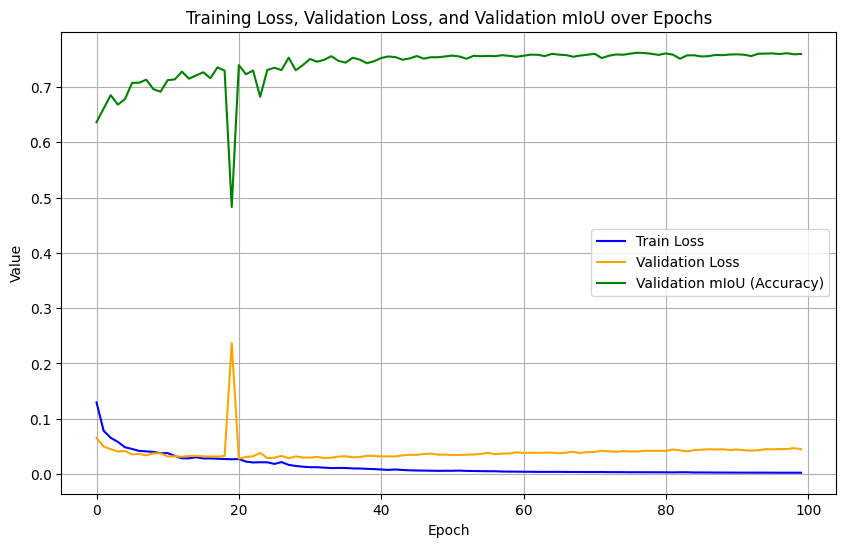

In [19]:
# Assuming train_loss_list, val_loss_list, and val_mIoU_list are already defined
plt.figure(figsize=(10, 6))

# Plot training loss
plt.plot(train_loss_list, label='Train Loss', color='blue')
# Plot validation loss
plt.plot(val_loss_list, label='Validation Loss', color='orange')
# Plot validation mIoU (accuracy)
plt.plot(val_mIoU_list, label='Validation mIoU (Accuracy)', color='green')

# Adding titles and labels
plt.title('Training Loss, Validation Loss, and Validation mIoU over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid()

# Show the plot
plt.show()